In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display

In [2]:
%matplotlib inline

In [3]:
flynumbers = list(range(1389,1402))
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in flylist]
#fly = flylist[4]
#fly.open_signals()

In [429]:
sorted_keys = sorted(flylist[0].spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd'),
            ('left', 'iii1'),('right', 'iii1'),
            ('left', 'i2'),('right', 'i2'),
            ('left', 'b1'),('right', 'b1'),
            ('left', 'b2'),('right', 'b2'),
            ('left', 'hg2'),('right', 'hg2'),
            ('left', 'hg3'),('right', 'hg3'),
            ('left', 'hg4'),('right', 'hg4')]

for cull in cull_list:
    sorted_keys.remove(cull)
#[sorted_keys.remove(cull) for cull in cull_list]

In [519]:
def make_state_matrix(flylist,
                     sorted_keys,
                     block_key = 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'):
    state_mtrxs = []
    left = []
    right = []
    lmr = []
    stim_key = ('common','idx',block_key)
    for fly in flylist:
        state_mtrx = np.vstack([fly.spikestates[key] for key in sorted_keys])
        #key = ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0')
        #key = ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0')
        idx_list = fly.block_data[stim_key]
        state_mtrxs.extend([np.array(state_mtrx[:,idx[100:]]) for idx in idx_list])
        left.extend([np.array(fly.left_amp)[idx[100:]] for idx in idx_list])
        right.extend([np.array(fly.right_amp)[idx[100:]] for idx in idx_list])
        lmr.extend([np.array(fly.left_amp)[idx[100:]]-np.array(fly.right_amp)[idx[100:]] 
                    for idx in idx_list])
    state_mtrx = np.hstack(state_mtrxs)
    state_mtrx = state_mtrx.astype(int)
    return state_mtrx,np.vstack(left),np.vstack(right)

In [520]:
state_mtrx,left,right = make_state_matrix(flylist,sorted_keys,
                                 block_key = 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0')

In [523]:
def get_transiton_prob(state_mtrx):
    tprob = {}
    state_list = [tuple(row) for row in state_mtrx.T]
    state_set = set(state_list)
    state_counts = {}
    for state in state_set:
        state_counts[state] = np.sum(np.sum(state==state_mtrx.T,axis = 1)==8)
    tprob = {}
    for col1,col2 in zip(state_mtrx.T[:-1],state_mtrx.T[1:]):
        if (tuple(col1),tuple(col2)) in tprob.keys():
            tprob[tuple(col1),tuple(col2)] += 1
        else:
            tprob[tuple(col1),tuple(col2)] = 1
    return tprob,state_counts

In [524]:
tprob,state_counts = get_transiton_prob(state_mtrx)

In [559]:
def make_transition_matrix(tprob,
                           state_counts,
                           min_tran_num = 1,
                           min_state_num = 10):
    filtered = {}
    for key,tnum in tprob.items():
        if (tnum > min_tran_num) & \
              (state_counts[key[0]] > min_state_num) & \
              (state_counts[key[1]]> min_state_num):
            filtered[key] = tnum

    inkeys = [x[0] for x in filtered.keys()]
    outkeys = [x[1] for x in filtered.keys()]

    filterd_set = list(set(inkeys + outkeys))
    transition_mtrx = np.zeros((len(filterd_set),len(filterd_set)))

    for i,state1 in enumerate(filterd_set):
        for j,state2 in enumerate(filterd_set):
            try:
                transition_mtrx[i,j] = filtered[state1,state2]
            except KeyError:
                pass

    transition_mtrx = transition_mtrx/np.sum(transition_mtrx,axis = 1)[:,None]
    transition_mtrx[np.isnan(transition_mtrx)] = 0
    sidx = np.argsort(np.diag(transition_mtrx))[::-1]
    transition_mtrx = transition_mtrx[sidx].T[sidx]
    state_table = np.array(filterd_set)[sidx,:]
    return transition_mtrx,state_table

In [560]:
transition_mtrx,state_table = make_transition_matrix(tprob,state_counts,min_state_num = 10,min_tran_num = 1)

In [561]:
def to_mstr(state_tuple):
    return ([{0:' ',1:' %s%-3s'%(sorted_keys[i][0][0],sorted_keys[i][1])}[s] for i,s in enumerate(state_tuple)])

In [563]:
def next_state(current_state,state_table,tmtrx):
    """simulate a markov step using transition matrx"""
    from numpy import random
    state_idx = np.squeeze(np.argwhere(np.all(state_table == current_state,axis = 1)))
    #print state_idx
    prob_vector = tmtrx[:,state_idx]
    #print prob_vector
    idx = random.choice(np.arange(len(state_table)),p = prob_vector)
    return state_table[idx]

#simulated_state_list = [[1,0,1,0,1,0,0,1]] #initial conditions, shouldn't matter for steady-state
simulated_state_list = [state_table[10]]
for i in range(5000):
    simulated_state_list.append(next_state(simulated_state_list[-1],
                                           state_table,
                                           transition_mtrx))
simulated_states = np.array(simulated_state_list).T

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log


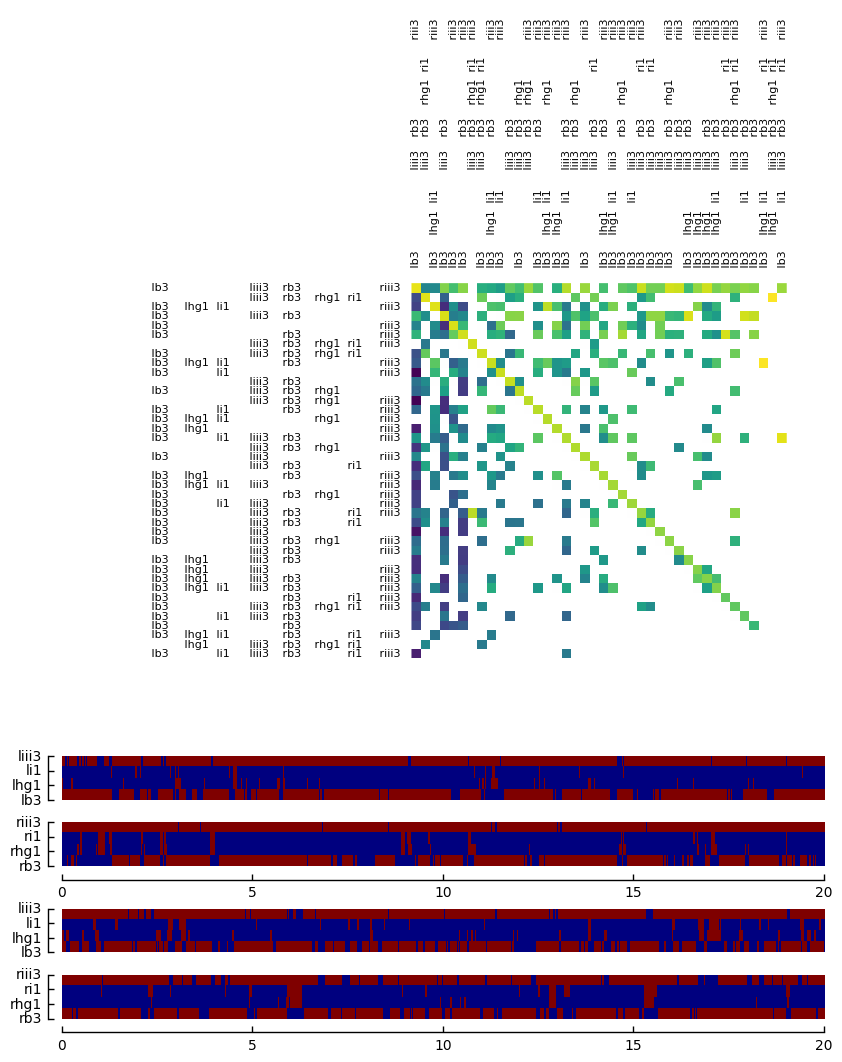

In [602]:
layout = fifi.FigureLayout('markov_analysis_layout.svg',make_mplfigures = True)
#plt.close('all')

ax_tmtrx = layout.axes['transition_mtrx']
ax_lbls_left = layout.axes['state_labels_left']
ax_lbls_top = layout.axes['state_labels_top']

ax_observed_left = layout.axes[u'observed_states', u'left']
ax_observed_right = layout.axes[u'observed_states', u'right']
ax_sim_left = layout.axes[u'simulated_states', u'left']
ax_sim_right = layout.axes[u'simulated_states', u'right']

extnt = [0,0.02*1000,0,3]
ax_observed_left.imshow(state_mtrx[:4,2000:3000],aspect = 'auto',interpolation = 'nearest',extent = extnt)
ax_observed_right.imshow(state_mtrx[4:,2000:3000],aspect = 'auto',interpolation = 'nearest',extent = extnt)
ax_observed_left.set_yticks(range(4))
ax_observed_left.set_yticklabels(['%s%s'%(k[0][0],k[1]) for k in sorted_keys[:4]])
ax_observed_right.set_yticks(range(4))
ax_observed_right.set_yticklabels(['%s%s'%(k[0][0],k[1]) for k in sorted_keys[4:]])

ax_sim_left.imshow(simulated_states[:4,2000:3000],aspect = 'auto',interpolation = 'nearest',extent = extnt)
ax_sim_right.imshow(simulated_states[4:,2000:3000],aspect = 'auto',interpolation = 'nearest',extent = extnt)
ax_sim_left.set_yticks(range(4))
ax_sim_left.set_yticklabels(['%s%s'%(k[0][0],k[1]) for k in sorted_keys[:4]])
ax_sim_right.set_yticks(range(4))
ax_sim_right.set_yticklabels(['%s%s'%(k[0][0],k[1]) for k in sorted_keys[4:]])

ax_tmtrx.imshow(np.log(transition_mtrx),interpolation = 'none',
          cmap = plt.cm.viridis)
#plt.gca().set_yticks(range(state_table.shape[1]))
#ax_lbls_left.imshow(state_table, extent =  [0,0,state_table.shape[1]*3,state_table.shape[0]])
for row,state in enumerate(state_table[::-1]):
    for i,onoff in enumerate(state):
        ax_lbls_left.text(3*i+1,row+1,{0:'',1:' %s%-5s'%(sorted_keys[i][0][0],
                                                sorted_keys[i][1])}[onoff],
                          fontsize = 8,
                          horizontalalignment='left',
                          verticalalignment='bottom')
        
for col,state in enumerate(state_table):
    for i,onoff in enumerate(state):
        ax_lbls_top.text(col+1,3*i+1,{0:'',1:' %s%-5s'%(sorted_keys[i][0][0],
                                                sorted_keys[i][1])}[onoff],
                          fontsize = 8,rotation = 90,
                          horizontalalignment='left',
                          verticalalignment='bottom')

ax_lbls_left.set_xbound(state_table.shape[1]*3)
ax_lbls_left.set_ybound(state_table.shape[0]+1)

ax_lbls_top.set_ybound(state_table.shape[1]*3)
ax_lbls_top.set_xbound(state_table.shape[0]+0.9)
fifi.mpl_functions.set_spines(layout)

In [539]:
np.shape(state_mtrx)

(8, 20650)

In [540]:
from thllib import util

In [541]:
left = util.fill_nan(left)
right = util.fill_nan(right)

In [542]:
kernel_len = 50
left_features = []
right_features = []
for idx in np.arange(kernel_len):
    mt =state_mtrx[:4,idx:-1*kernel_len+idx]
    left_features.append(mt)
    mt =state_mtrx[4:,idx:-1*kernel_len+idx]
    right_features.append(mt)

In [574]:
strt = 0
stop = 10000
left_ = left[strt:stop]
right_ = right[strt:stop]

A_L = np.vstack(left_features)[:,strt:stop]
inv_L = np.linalg.pinv(A_L.T)
X_L = np.dot(inv_L,left_)#[:-1*kernel_len])

A_R = np.vstack(right_features)[:,strt:stop]
inv_R = np.linalg.pinv(A_R.T)
X_R = np.dot(inv_R,right_)#[:-1*kernel_len])

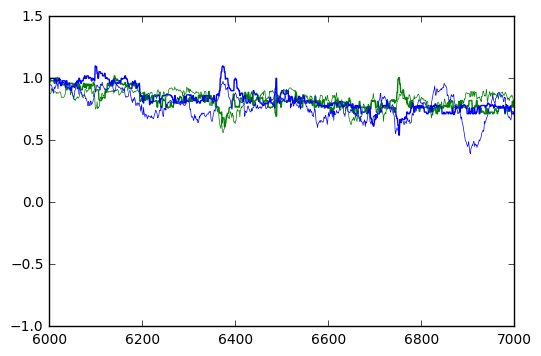

In [588]:
plt.plot(left_,'g')
plt.plot(right_,'b')
plt.plot(np.dot(A_L.T,X_L),'green',lw = 0.5)
plt.plot(np.dot(A_R.T,X_R),'b',lw = 0.5)
plt.gca().set_xbound(6000,7000)

In [557]:
s0 = np.array([1,0,0,1,1,0,0,1])
s1 = np.array([1,1,1,0,0,0,0,1])
s2 = np.array([0,0,0,1,1,1,1,0])
s0_idx = np.all(state_mtrx == s0[:,None],axis = 0)
s1_idx = np.all(state_mtrx == s1[:,None],axis = 0)
s2_idx = np.all(state_mtrx == s2[:,None],axis = 0)

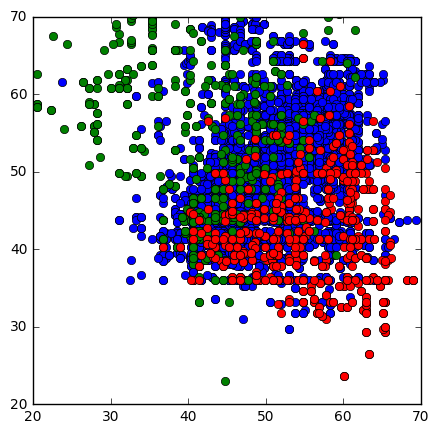

In [558]:
plt.figure(figsize = (5,5))
plt.plot(np.rad2deg(np.vstack(left)[s0_idx]),
         np.rad2deg(np.vstack(right)[s0_idx]),'o')
plt.plot(np.rad2deg(np.vstack(left)[s1_idx]),
         np.rad2deg(np.vstack(right)[s1_idx]),'o')
plt.plot(np.rad2deg(np.vstack(left)[s2_idx]),
         np.rad2deg(np.vstack(right)[s2_idx]),'o')
plt.gca().set_xbound(20,70)
plt.gca().set_ybound(20,70)